# Neuron Alignment + REPAIR + Adversarial robustness + MTD

* The code in this notebook uses Jordan Keller's code to align models and apply REPAIR: https://github.com/KellerJordan/REPAIR.git
  - https://github.com/KellerJordan/REPAIR/blob/master/notebooks/Train-and-Permute-CIFAR10-VGG11-BatchNorm.ipynb

* `torchattacks` library is used for the implementation of adversarial attacks: https://github.com/Harry24k/adversarial-attacks-pytorch.git

# Imports and helpful functions

In [ ]:
!pip install git+https://github.com/Harry24k/adversarial-attacks-pytorch.git

In [ ]:
import math
import random
import scipy

import torch
from torch import nn, Tensor

from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
import torchvision
import torchvision.transforms as T

from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor, Lambda, Compose, RandomRotation, Resize, Grayscale
import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter, UninitializedParameter
import torch.nn.functional as F
from torch.nn.modules.module import Module
from torch.nn import init
from tqdm.notebook import trange, tqdm
import torchvision.transforms.functional as TF
from typing import Optional, List, Tuple, Union
from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
import itertools
import numpy as np

import torchattacks

import copy
import io
import os

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
## a directory to save VGG checkpoints
os.makedirs('./vgg', exist_ok=True)
def save_model(model, i):
    sd = model.state_dict()
    torch.save(model.state_dict(), 'vgg/%s.pt' % i)

def load_model(model, i):
    sd = torch.load('vgg/%s.pt' % i)
    model.load_state_dict(sd)

# Load Data

In [ ]:
class Clamp(object):
  def __init__(self):
    pass
  def __call__(self, sample):
        return torch.clamp(sample, 0,1)


def load_data(split, dataset_name, datadir, nchannels):
    ## https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151
    if dataset_name == 'MNIST':
        normalize = transforms.Normalize(mean=[0.1307], std=[0.3081])
    elif dataset_name == 'SVHN':
        # normalize = transforms.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970])
        normalize = transforms.Normalize(mean=[0.4377], std=[0.1980])
    elif dataset_name == 'CIFAR10':
        normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
    elif dataset_name == 'CIFAR100':
        normalize = transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
    elif dataset_name == 'imagenet':
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    if dataset_name == 'imagenet':
        tr_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                                           transforms.RandomHorizontalFlip(), transforms.ToTensor(), normalize])
        val_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                                           transforms.RandomHorizontalFlip(), transforms.ToTensor(), normalize])
    elif dataset_name == 'SVHN':
        tr_transform = transforms.Compose([transforms.Resize(32), transforms.Grayscale(), transforms.ToTensor(), normalize, Clamp()])
        val_transform = transforms.Compose([transforms.Resize(32), transforms.Grayscale(), transforms.ToTensor(), normalize, Clamp()])
    elif dataset_name == 'CIFAR10':
        tr_transform = transforms.Compose([transforms.Resize(32),
                                           T.RandomHorizontalFlip(),
                                           T.RandomCrop(32, padding=4),
                                           transforms.ToTensor(), normalize, Clamp()])
        val_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), normalize, Clamp()])
    elif dataset_name == 'GTSRB':
        tr_transform = transforms.Compose([transforms.Resize(42), transforms.Grayscale(), transforms.CenterCrop(32), transforms.ToTensor()])
        val_transform = transforms.Compose([transforms.Resize(42), transforms.Grayscale(), transforms.CenterCrop(32), transforms.ToTensor()])
    else:
        tr_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), normalize])
        val_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), normalize])

    get_dataset = getattr(datasets, dataset_name)
    if dataset_name == 'SVHN':
        if split == 'train':
            dataset = get_dataset(root=datadir, split='train', download=True, transform=tr_transform)
        else:
            dataset = get_dataset(root=datadir, split='test', download=True, transform=val_transform)
    elif dataset_name == 'GTSRB':
        if split == 'train':
            dataset = datasets.GTSRB(root=datadir, split='train', download=True, transform=tr_transform)
        else:
            dataset = datasets.GTSRB(root=datadir, split='test', download=True, transform=tr_transform)
    else:
        if split == 'train':
            dataset = get_dataset(root=datadir, train=True, download=True, transform=tr_transform)
        else:
            dataset = get_dataset(root=datadir, train=False, download=True, transform=val_transform)

    return dataset

In [ ]:
# CIFAR10
batch_size = 512
nchannels = 3
train_dataset = load_data("train", "CIFAR10", "datasets", nchannels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = load_data("test", "CIFAR10", "datasets", nchannels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Shape of X [N, C, H, W]:  torch.Size([512, 3, 32, 32])
Shape of y:  torch.Size([512]) torch.int64
tensor(3)
tensor(1.)
tensor(0.)


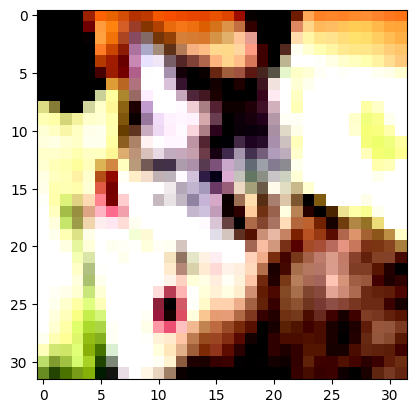

In [ ]:
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

X = X.permute(0,2,3,1)
plt.imshow(X[8,:,:,:])
print(y[8])
# print(X[8,:,:,:])
print(torch.max(X[:,:,:,:]))
print(torch.min(X[:,:,:,:]))

# Evaluation Functions

In [ ]:
# evaluates accuracy
def evaluate(model, loader=test_dataloader):
    model.eval()
    correct = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
    return correct

# evaluates loss
def evaluate1(model, loader=test_dataloader):
    model.eval()
    losses = []
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            loss = F.cross_entropy(outputs, labels.cuda())
            losses.append(loss.item())
    return np.array(losses).mean()

# evaluates acc and loss
def evaluate2(model, loader=test_dataloader):
    model.eval()
    losses = []
    correct = 0
    total = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            total += len(labels)
            loss = F.cross_entropy(outputs, labels.cuda())
            losses.append(loss.item())
    return correct / total, np.array(losses).mean()

def full_eval1(model):
    tr_acc, tr_loss = evaluate2(model, loader=train_dataloader)
    te_acc, te_loss = evaluate2(model, loader=test_dataloader)
    return '%.2f, %.3f, %.2f, %.3f' % (100*tr_acc, tr_loss, 100*te_acc, te_loss)

def full_eval(model):
    tr_acc, tr_loss = evaluate2(model, loader=train_dataloader)
    te_acc, te_loss = evaluate2(model, loader=test_dataloader)
    return (100*tr_acc, tr_loss, 100*te_acc, te_loss)

# Models



In [ ]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name, w=1):
        super(VGG, self).__init__()
        self.vgg_name = vgg_name
        self.w = w
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(self.w*512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers.append(nn.Conv2d(in_channels if in_channels == 3 else self.w*in_channels,
                                     self.w*x, kernel_size=3, padding=1))
                layers.append(nn.BatchNorm2d(self.w*x))
                layers.append(nn.ReLU(inplace=True))
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

# Train and save two models

In [ ]:
def train(w=1):
    model = VGG('VGG11', w=w).cuda()
    optimizer = SGD(model.parameters(), lr=0.08, momentum=0.9, weight_decay=5e-4)

    EPOCHS = 100
    ne_iters = len(train_dataloader)
    lr_schedule = np.interp(np.arange(1+EPOCHS*ne_iters), [0, 5*ne_iters, EPOCHS*ne_iters], [0, 1, 0])
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_schedule.__getitem__)

    scaler = GradScaler()
    loss_fn = CrossEntropyLoss()

    losses = []
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad(set_to_none=True)
            with autocast():
                outputs = model(inputs.cuda())
                loss = loss_fn(outputs, labels.cuda())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            losses.append(loss.item())
    return model

In [ ]:
w = 1
model = train(w)
print(evaluate(model))
save_model(model, 'vgg11x%d_bn_C' % w)

model = train(w)
print(evaluate(model))
save_model(model, 'vgg11x%d_bn_D' % w)

  0%|          | 0/100 [00:00<?, ?it/s]

8518


  0%|          | 0/100 [00:00<?, ?it/s]

8525


#Matching code

In [ ]:
# given two networks net0, net1 which each output a feature map of shape NxCxWxH
# this will reshape both outputs to (N*W*H)xC
# and then compute a CxC correlation matrix between the outputs of the two networks
def run_corr_matrix(net0, net1, epochs=1, norm=True, loader=train_dataloader):
    n = epochs*len(loader)
    mean0 = mean1 = std0 = std1 = None
    with torch.no_grad():
        net0.eval()
        net1.eval()
        for _ in range(epochs):
            for i, (images, _) in enumerate(tqdm(loader)):
                img_t = images.float().cuda()
                out0 = net0(img_t)
                out0 = out0.reshape(out0.shape[0], out0.shape[1], -1).permute(0, 2, 1)
                out0 = out0.reshape(-1, out0.shape[2]).double()

                out1 = net1(img_t)
                out1 = out1.reshape(out1.shape[0], out1.shape[1], -1).permute(0, 2, 1)
                out1 = out1.reshape(-1, out1.shape[2]).double()

                mean0_b = out0.mean(dim=0)
                mean1_b = out1.mean(dim=0)
                std0_b = out0.std(dim=0)
                std1_b = out1.std(dim=0)
                outer_b = (out0.T @ out1) / out0.shape[0]

                if i == 0:
                    mean0 = torch.zeros_like(mean0_b)
                    mean1 = torch.zeros_like(mean1_b)
                    std0 = torch.zeros_like(std0_b)
                    std1 = torch.zeros_like(std1_b)
                    outer = torch.zeros_like(outer_b)
                mean0 += mean0_b / n
                mean1 += mean1_b / n
                std0 += std0_b / n
                std1 += std1_b / n
                outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    if norm:
        corr = cov / (torch.outer(std0, std1) + 1e-4)
        return corr
    else:
        return cov

In [ ]:
def get_layer_perm1(corr_mtx):
    corr_mtx_a = corr_mtx.cpu().numpy()
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(corr_mtx_a, maximize=True)
    assert (row_ind == np.arange(len(corr_mtx_a))).all()
    perm_map = torch.tensor(col_ind).long()
    return perm_map

# returns the channel-permutation to make layer1's activations most closely
# match layer0's.
def get_layer_perm(net0, net1):
    corr_mtx = run_corr_matrix(net0, net1)
    return get_layer_perm1(corr_mtx)

# modifies the weight matrices of a convolution and batchnorm
# layer given a permutation of the output channels
def permute_output(perm_map, conv, bn):
    pre_weights = [
        conv.weight,
    ]
    if conv.bias is not None:
        pre_weights.append(conv.bias)
    if bn is not None:
        pre_weights.extend([
            bn.weight,
            bn.bias,
            bn.running_mean,
            bn.running_var,
        ])
    for w in pre_weights:
        w.data = w[perm_map]

# modifies the weight matrix of a layer for a given permutation of the input channels
# works for both conv2d and linear
def permute_input(perm_map, layer):
    w = layer.weight
    w.data = w[:, perm_map]

# Find neuron-permutation for each layer

In [ ]:
w=1
model0 = VGG('VGG11', w=w).cuda()
model1 = VGG('VGG11', w=w).cuda()
load_model(model0, 'vgg11x%d_bn_W10' % w)
load_model(model1, 'vgg11x%d_bn_D' % w)

evaluate(model0), evaluate(model1)

(7756, 8363)

In [ ]:
def subnet(model, n_layers):
    return model.features[:n_layers]

feats1 = model1.features

n = len(feats1)
for i in range(n):
    layer = feats1[i]
    if isinstance(layer, nn.Conv2d):
        # get permutation and permute output of conv and maybe bn
        if isinstance(feats1[i+1], nn.BatchNorm2d):
            assert isinstance(feats1[i+2], nn.ReLU)
            perm_map = get_layer_perm(subnet(model0, i+3), subnet(model1, i+3))
            permute_output(perm_map, feats1[i], feats1[i+1])
        else:
            assert isinstance(feats1[i+1], nn.ReLU)
            perm_map = get_layer_perm(subnet(model0, i+2), subnet(model1, i+2))
            permute_output(perm_map, feats1[i], None)
        # look for succeeding layer to permute input
        next_layer = None
        for j in range(i+1, n):
            if isinstance(feats1[j], nn.Conv2d):
                next_layer = feats1[j]
                break
        if next_layer is None:
            next_layer = model1.classifier
        permute_input(perm_map, next_layer)

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
# ensure accuracy didn't change
# (it may be slightly different due to non-associativity of floating point arithmetic)
print(evaluate(model1))
save_model(model1, 'vgg11x%d_bn_D_perm_W10' % w)

8363


# Evaluate the interpolated network

In [ ]:
def mix_weights(model, alpha, key0, key1):
    sd0 = torch.load('vgg/%s.pt' % key0)
    sd1 = torch.load('vgg/%s.pt' % key1)
    sd_alpha = {k: (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
                for k in sd0.keys()}
    model.load_state_dict(sd_alpha)

# use the train loader with data augmentation as this gives better results
def reset_bn_stats(model, epochs=1, loader=train_dataloader):
    # resetting stats to baseline first as below is necessary for stability
    for m in model.modules():
        if type(m) == nn.BatchNorm2d:
            m.momentum = None # use simple average
            m.reset_running_stats()
    # run a single train epoch with augmentations to recalc stats
    model.train()
    for _ in range(epochs):
        with torch.no_grad(), autocast():
            for images, _ in loader:
                output = model(images.cuda())

In [ ]:
model_a = VGG('VGG11', w=w).cuda()

k0 = 'vgg11x%d_bn_v1b' % w
k1 = 'vgg11x%d_bn_v2b' % w

print('With neither permutation nor correction')
for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
    mix_weights(model_a, alpha, k0, k1)
    print('(α=%.2f)' % alpha, full_eval(model_a))

In [ ]:
model_a = VGG('VGG11', w=w).cuda()

k0 = 'vgg11x%d_bn_v1b' % w
k1 = 'vgg11x%d_bn_v2b_perm1b' % w # **

print('With permutation but no correction')
for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
    mix_weights(model_a, alpha, k0, k1)
    print('(α=%.2f)' % alpha, full_eval(model_a))


In [ ]:
model_a = VGG('VGG11', w=w).cuda()

k0 = 'vgg11x%d_bn_v1b' % w
k1 = 'vgg11x%d_bn_v2b_perm1b' % w

print('With both permutation and correction')
for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
    mix_weights(model_a, alpha, k0, k1)
    reset_bn_stats(model_a) # **
    print('(α=%.2f)' % alpha, full_eval(model_a))

In [ ]:
w=1

model_a = VGG('VGG11', w=w).cuda()
k0 = 'vgg11x%d_bn_W10' % w
k1 = 'vgg11x%d_bn_D_perm_W10' % w
mix_weights(model_a, 0.5, k0, k1)
reset_bn_stats(model_a) # **
print('(α=0.5)', full_eval(model_a))

save_model(model_a, 'vgg11x%d_bn_W11' % w)

(α=0.5) (86.45, 0.4883176945910162, 77.39, 1.0660673469305038)


# Attacks

##Static ensembles

In [ ]:
w=1

In [ ]:
def attack_with_torchattacks(model, attack, xline, dataloader):
    print(f'Testing {attack} attack on ensemble')

    model.eval().to(device)
    acc_list = []

    for k, x in enumerate(xline):
      eps = Tensor([x]).to(device)
      sum_correct = 0

      for i, (data, target) in enumerate(dataloader):
          data, target = data.to(device), target.to(device)

          ## attacks: https://arxiv.org/pdf/2010.01950.pdf
          if attack=="FGSM":
              atk = torchattacks.FGSM(model, eps=eps)
          elif attack == "PGD":
              atk = torchattacks.PGD(model, eps=eps, alpha=4/255, steps=2, random_start=False)
          adversarial_examples = atk(data, target)

          # Re-classify the perturbed image
          output = model(adversarial_examples)
          final_pred = output.max(1)[1]  # get the index of the max log-probability
          correct = final_pred.eq(target).sum().item()

          sum_correct += correct

      accuracy = sum_correct / len(dataloader.dataset)
      print(f'Test {k + 1}, accuracy={accuracy}')
      acc_list.append(accuracy)

    return acc_list

[(0.0, 0.0, 0.5, 1.0), (0.0, 0.06470588235294118, 1.0, 1.0), (0.0, 0.6450980392156863, 1.0, 1.0), (0.24984187223276405, 1.0, 0.717900063251107, 1.0), (0.7179000632511068, 1.0, 0.2498418722327641, 1.0), (1.0, 0.7269426289034134, 0.0, 1.0), (1.0, 0.18954248366013093, 0.0, 1.0), (0.5, 0.0, 0.0, 1.0)]
A
Testing FGSM attack on ensemble
Test 1, accuracy=0.8348
Test 2, accuracy=0.3411
Test 3, accuracy=0.158
Test 4, accuracy=0.089
Test 5, accuracy=0.0578
P
Testing FGSM attack on ensemble
Test 1, accuracy=0.7882
Test 2, accuracy=0.3278
Test 3, accuracy=0.1422
Test 4, accuracy=0.0738
Test 5, accuracy=0.0476
Q
Testing FGSM attack on ensemble
Test 1, accuracy=0.7703
Test 2, accuracy=0.3166
Test 3, accuracy=0.1419
Test 4, accuracy=0.0746
Test 5, accuracy=0.0559
R
Testing FGSM attack on ensemble
Test 1, accuracy=0.762
Test 2, accuracy=0.3118
Test 3, accuracy=0.1377
Test 4, accuracy=0.0817
Test 5, accuracy=0.0604
S
Testing FGSM attack on ensemble
Test 1, accuracy=0.7728
Test 2, accuracy=0.3168
Test 3

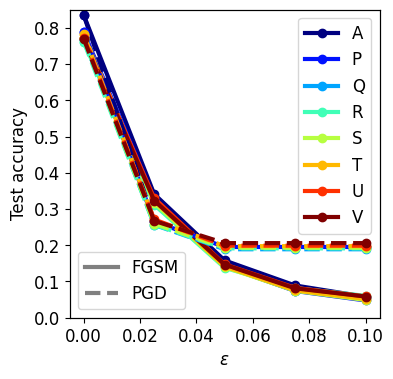

In [ ]:
from matplotlib import cm

colors = [ cm.jet(x) for x in np.linspace(0, 1, 8) ]
print(colors)
w=1
xline = np.linspace(0.0, 0.1, 5)

mnames = ['A', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12)

fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111)

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = VGG('VGG11', w=w).cuda()
    load_model(model0, 'vgg11x%d_bn_%s' % (w, mn))
    acc_list_1 = attack_with_torchattacks(model0, "FGSM", xline, test_dataloader)
    ax.plot(xline, acc_list_1, f'-o', label=f"{mn}", lw=3, color=cn)

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = VGG('VGG11', w=w).cuda()
    load_model(model0, 'vgg11x%d_bn_%s' % (w, mn))
    acc_list_2 = attack_with_torchattacks(model0, "PGD", xline, test_dataloader)
    ax.plot(xline, acc_list_2, f'--o', lw=3, color=cn)

ax2 = ax.twinx()
ax2.plot(0, -1, f'-', color='grey', lw=3, label='FGSM')
ax2.plot(0, -1, f'--', color='grey', lw=3, label='PGD')
ax2.get_yaxis().set_visible(False)

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Test accuracy')
ax.set_ylim([0,0.85])
ax.legend(loc=1)
ax2.legend(loc=3)
plt.show()

## Dynamic ensembles

In [ ]:
def attack_with_torchattacks_endpoints(model, endpoint, attack, xline, dataloader):
    print(f'Testing {attack} attack on ensemble')

    model.eval().to(device)
    acc_list = []

    for k, x in enumerate(xline):
      eps = Tensor([x]).to(device)
      sum_correct = 0

      for i, (data, target) in enumerate(dataloader):
          data, target = data.to(device), target.to(device)

          ## attacks: https://arxiv.org/pdf/2010.01950.pdf
          if attack=="FGSM":
              atk = torchattacks.FGSM(endpoint, eps=eps)
          elif attack == "PGD":
              atk = torchattacks.PGD(endpoint, eps=eps, alpha=4/255, steps=2, random_start=False)
          adversarial_examples = atk(data, target)

          # Re-classify the perturbed image
          output = model(adversarial_examples)
          final_pred = output.max(1)[1]  # get the index of the max log-probability
          correct = final_pred.eq(target).sum().item()

          sum_correct += correct

      accuracy = sum_correct / len(dataloader.dataset)
      print(f'Test {k + 1}, accuracy={accuracy}')
      acc_list.append(accuracy)

    return acc_list

[(0.0, 0.0, 0.5, 1.0), (0.0, 0.06470588235294118, 1.0, 1.0), (0.0, 0.6450980392156863, 1.0, 1.0), (0.24984187223276405, 1.0, 0.717900063251107, 1.0), (0.7179000632511068, 1.0, 0.2498418722327641, 1.0), (1.0, 0.7269426289034134, 0.0, 1.0), (1.0, 0.18954248366013093, 0.0, 1.0), (0.5, 0.0, 0.0, 1.0)]
A
Testing FGSM attack on ensemble
Test 1, accuracy=0.8348
Test 2, accuracy=0.3411
Test 3, accuracy=0.158
Test 4, accuracy=0.089
Test 5, accuracy=0.0578
P
Testing FGSM attack on ensemble
Test 1, accuracy=0.7882
Test 2, accuracy=0.5689
Test 3, accuracy=0.3911
Test 4, accuracy=0.2751
Test 5, accuracy=0.2069
Q
Testing FGSM attack on ensemble
Test 1, accuracy=0.7703
Test 2, accuracy=0.6045
Test 3, accuracy=0.4562
Test 4, accuracy=0.3413
Test 5, accuracy=0.2642
R
Testing FGSM attack on ensemble
Test 1, accuracy=0.762
Test 2, accuracy=0.6116
Test 3, accuracy=0.4603
Test 4, accuracy=0.3523
Test 5, accuracy=0.2743
S
Testing FGSM attack on ensemble
Test 1, accuracy=0.7728
Test 2, accuracy=0.5185
Test 3

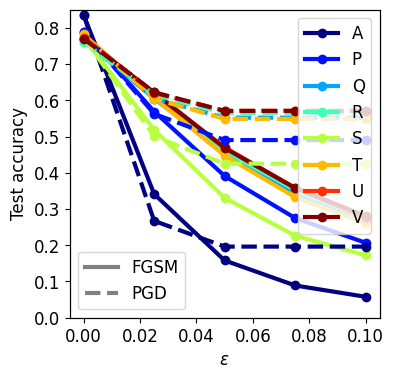

In [ ]:
from matplotlib import cm

colors = [ cm.jet(x) for x in np.linspace(0, 1, 8) ]
print(colors)
w=1
xline = np.linspace(0.0, 0.1, 5)

mnames = ['A', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12)

fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111)

model1 = VGG('VGG11', w=w).cuda()
load_model(model1, 'vgg11x%d_bn_A' % w)

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = VGG('VGG11', w=w).cuda()
    load_model(model0, 'vgg11x%d_bn_%s' % (w, mn))
    acc_list_1 = attack_with_torchattacks_endpoints(model0, model1, "FGSM", xline, test_dataloader)
    ax.plot(xline, acc_list_1, f'-o', label=f"{mn}", lw=3, color=cn)

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = VGG('VGG11', w=w).cuda()
    load_model(model0, 'vgg11x%d_bn_%s' % (w, mn))
    acc_list_2 = attack_with_torchattacks_endpoints(model0, model1, "PGD", xline, test_dataloader)
    ax.plot(xline, acc_list_2, f'--o', lw=3, color=cn)

ax2 = ax.twinx()
ax2.plot(0, -1, f'-', color='grey', lw=3, label='FGSM')
ax2.plot(0, -1, f'--', color='grey', lw=3, label='PGD')
ax2.get_yaxis().set_visible(False)

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Test accuracy')
ax.set_ylim([0,0.85])
ax.legend(loc=1)
ax2.legend(loc=3)
plt.show()

In [ ]:
def attack_with_torchattacks_4_endpoints(model, e1, e2, e3, e4, attack, xline, dataloader):
    print(f'Testing {attack} attack on ensemble')

    model.eval().to(device)
    acc_list = []

    for k, x in enumerate(xline):
      eps = Tensor([x]).to(device)
      sum_correct = 0

      for i, (data, target) in enumerate(dataloader):
          data, target = data.to(device), target.to(device)

          ## attacks: https://arxiv.org/pdf/2010.01950.pdf
          if attack=="FGSM":
              atk1 = torchattacks.FGSM(e1, eps=eps)
              atk2 = torchattacks.FGSM(e2, eps=eps)
              atk3 = torchattacks.FGSM(e3, eps=eps)
              atk4 = torchattacks.FGSM(e4, eps=eps)
          elif attack == "PGD":
              atk1 = torchattacks.PGD(e1, eps=eps, alpha=4/255, steps=2, random_start=False)
              atk2 = torchattacks.PGD(e2, eps=eps, alpha=4/255, steps=2, random_start=False)
              atk3 = torchattacks.PGD(e3, eps=eps, alpha=4/255, steps=2, random_start=False)
              atk4 = torchattacks.PGD(e4, eps=eps, alpha=4/255, steps=2, random_start=False)
          adversarial_examples1 = atk1(data, target)
          adversarial_examples2 = atk2(data, target)
          adversarial_examples3 = atk3(data, target)
          adversarial_examples4 = atk4(data, target)

          # Re-classify the perturbed image
          output1 = model(adversarial_examples1)
          final_pred1 = output1.max(1)[1]  # get the index of the max log-probability
          correct1 = final_pred1.eq(target).sum().item()

          # Re-classify the perturbed image
          output2 = model(adversarial_examples2)
          final_pred2 = output2.max(1)[1]  # get the index of the max log-probability
          correct2 = final_pred2.eq(target).sum().item()

          # Re-classify the perturbed image
          output3 = model(adversarial_examples3)
          final_pred3 = output3.max(1)[1]  # get the index of the max log-probability
          correct3 = final_pred3.eq(target).sum().item()

          # Re-classify the perturbed image
          output4 = model(adversarial_examples4)
          final_pred4 = output4.max(1)[1]  # get the index of the max log-probability
          correct4 = final_pred4.eq(target).sum().item()

          sum_correct += (correct1 + correct2 + correct3 + correct4) / 4

      accuracy = sum_correct / len(dataloader.dataset)
      print(f'Test {k + 1}, accuracy={accuracy}')
      acc_list.append(accuracy)

    return acc_list

[(0.0, 0.0, 0.5, 1.0), (0.0, 0.06470588235294118, 1.0, 1.0), (0.0, 0.6450980392156863, 1.0, 1.0), (0.24984187223276405, 1.0, 0.717900063251107, 1.0), (0.7179000632511068, 1.0, 0.2498418722327641, 1.0), (1.0, 0.7269426289034134, 0.0, 1.0), (1.0, 0.18954248366013093, 0.0, 1.0), (0.5, 0.0, 0.0, 1.0)]
A
Testing FGSM attack on ensemble
Test 1, accuracy=0.8348
Test 2, accuracy=0.578675
Test 3, accuracy=0.3995
Test 4, accuracy=0.282375
Test 5, accuracy=0.207525
P
Testing FGSM attack on ensemble
Test 1, accuracy=0.7882
Test 2, accuracy=0.60135
Test 3, accuracy=0.433925
Test 4, accuracy=0.3188
Test 5, accuracy=0.2453
Q
Testing FGSM attack on ensemble
Test 1, accuracy=0.7703
Test 2, accuracy=0.59415
Test 3, accuracy=0.44105
Test 4, accuracy=0.3269
Test 5, accuracy=0.252575
R
Testing FGSM attack on ensemble
Test 1, accuracy=0.762
Test 2, accuracy=0.591
Test 3, accuracy=0.4293
Test 4, accuracy=0.320675
Test 5, accuracy=0.247675
S
Testing FGSM attack on ensemble
Test 1, accuracy=0.7728
Test 2, accu

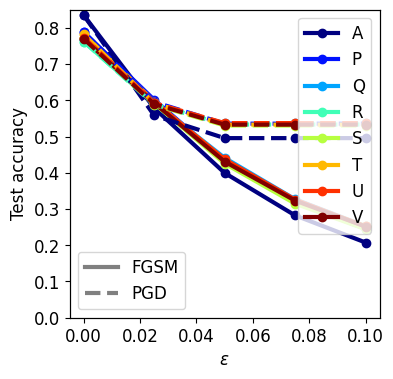

In [ ]:
from matplotlib import cm

colors = [ cm.jet(x) for x in np.linspace(0, 1, 8) ]
print(colors)
w=1
xline = np.linspace(0.0, 0.1, 5)

mnames = ['A', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12)

fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111)

model1 = VGG('VGG11', w=w).cuda()
load_model(model1, 'vgg11x%d_bn_A' % w)
model2 = VGG('VGG11', w=w).cuda()
load_model(model2, 'vgg11x%d_bn_B' % w)
model3 = VGG('VGG11', w=w).cuda()
load_model(model3, 'vgg11x%d_bn_C' % w)
model4 = VGG('VGG11', w=w).cuda()
load_model(model4, 'vgg11x%d_bn_D' % w)

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = VGG('VGG11', w=w).cuda()
    load_model(model0, 'vgg11x%d_bn_%s' % (w, mn))
    acc_list_1 = attack_with_torchattacks_4_endpoints(model0, model1, model2, model3, model4, "FGSM", xline, test_dataloader)
    ax.plot(xline, acc_list_1, f'-o', label=f"{mn}", lw=3, color=cn)

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = VGG('VGG11', w=w).cuda()
    load_model(model0, 'vgg11x%d_bn_%s' % (w, mn))
    acc_list_2 = attack_with_torchattacks_4_endpoints(model0, model1, model2, model3, model4, "PGD", xline, test_dataloader)
    ax.plot(xline, acc_list_2, f'--o', lw=3, color=cn)

ax2 = ax.twinx()
ax2.plot(0, -1, f'-', color='grey', lw=3, label='FGSM')
ax2.plot(0, -1, f'--', color='grey', lw=3, label='PGD')
ax2.get_yaxis().set_visible(False)

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Test accuracy')
ax.set_ylim([0,0.85])
ax.legend(loc=1)
ax2.legend(loc=3)
plt.show()

# Plots

A, B_perm_A --> cossim = 0.2528814673423767
A, C_perm_P --> cossim = 0.2346380054950714
A, D_perm_Q --> cossim = 0.2182866632938385
A, P --> cossim = 0.7907240390777588
A, Q --> cossim = 0.5946395397186279
A, R --> cossim = 0.460880845785141
A, S --> cossim = 0.6746248602867126
A, T --> cossim = 0.5060703754425049
A, U --> cossim = 0.41235053539276123
A, V --> cossim = 0.3560938537120819
B_perm_A, C_perm_P --> cossim = 0.23295249044895172
B_perm_A, D_perm_Q --> cossim = 0.21655619144439697
B_perm_A, P --> cossim = 0.7922350168228149
B_perm_A, Q --> cossim = 0.5943013429641724
B_perm_A, R --> cossim = 0.45947501063346863
B_perm_A, S --> cossim = 0.39073771238327026
B_perm_A, T --> cossim = 0.6785703897476196
B_perm_A, U --> cossim = 0.49854612350463867
B_perm_A, V --> cossim = 0.39907506108283997
C_perm_P, D_perm_Q --> cossim = 0.23601195216178894
C_perm_P, P --> cossim = 0.29538798332214355
C_perm_P, Q --> cossim = 0.8526060581207275
C_perm_P, R --> cossim = 0.6060182452201843
C_perm_P

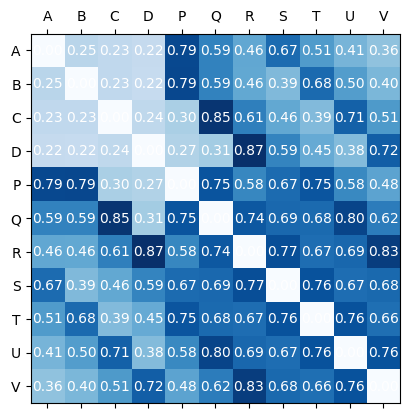

In [ ]:
from itertools import combinations
from matplotlib import ticker

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

def get_param_vector(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    return params

msp = ['A', 'B_perm_A', 'C_perm_P', 'D_perm_Q', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
ms = ['A', 'B', 'C', 'D', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
cs = np.zeros((len(ms),len(ms)))
for (i,j) in combinations(msp, r=2):
    load_model(model0, 'vgg11x%d_bn_%s' % (w, i))
    load_model(model1, 'vgg11x%d_bn_%s' % (w, j))

    r = cos(get_param_vector(model0), get_param_vector(model1)).detach().cpu().numpy()
    print(f'{i}, {j} --> cossim = {r}')
    cs[msp.index(i),msp.index(j)] = r
    cs[msp.index(j),msp.index(i)] = r

# print(cs)

fig, ax = plt.subplots()

ax.matshow(cs, cmap=plt.cm.Blues)
for i in range(len(ms)):
    for j in range(len(ms)):
        c = cs[j,i]
        ax.text(i, j, "{:.2f}".format(c), va='center', ha='center', color="w")

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticks(range(len(ms)))
ax.set_yticks(range(len(ms)))
ax.set_xticklabels(ms)
ax.set_yticklabels(ms)
plt.show()

A, B_perm_A --> cossim = 0.8752211421728134
A, C_perm_P --> cossim = 0.8758191645145417
A, D_perm_Q --> cossim = 0.877553454041481
A, P --> cossim = 0.8566818982362747
A, Q --> cossim = 0.8142488479614258
A, R --> cossim = 0.803758829832077
A, S --> cossim = 0.8538852274417877
A, T --> cossim = 0.8256423085927963
A, U --> cossim = 0.8174494475126266
A, V --> cossim = 0.8135365068912506
B_perm_A, C_perm_P --> cossim = 0.8725014925003052
B_perm_A, D_perm_Q --> cossim = 0.8740779429674148
B_perm_A, P --> cossim = 0.853190290927887
B_perm_A, Q --> cossim = 0.8088134884834289
B_perm_A, R --> cossim = 0.7977033913135528
B_perm_A, S --> cossim = 0.8105074495077134
B_perm_A, T --> cossim = 0.8513592898845672
B_perm_A, U --> cossim = 0.8157759755849838
B_perm_A, V --> cossim = 0.8073139518499375
C_perm_P, D_perm_Q --> cossim = 0.8759141892194748
C_perm_P, P --> cossim = 0.8298215270042419
C_perm_P, Q --> cossim = 0.8347005933523178
C_perm_P, R --> cossim = 0.8036380976438522
C_perm_P, S --> cos

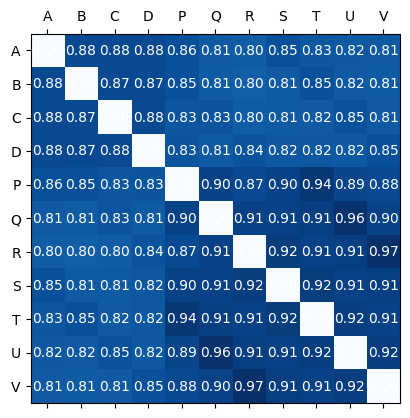

In [ ]:
def calculate_CKA(kernel1, kernel2):
    n = kernel1.shape[0]
    H = (torch.eye(n) - 1 / n).to(device)
    kernel1_centered = torch.mm(torch.mm(H, kernel1), H).to(device)
    kernel2_centered = torch.mm(torch.mm(H, kernel2), H).to(device)

    # Compute the CKA
    cka = torch.trace(torch.mm(kernel1_centered, kernel2_centered)) \
          / torch.sqrt(torch.trace(torch.mm(kernel1_centered, kernel1_centered))) \
          / torch.sqrt(torch.trace(torch.mm(kernel2_centered, kernel2_centered)))

    return cka

def ckasim(model0, model1):
    cka_list = np.array([])

    for X, y in test_dataloader:
        X = X.to(device)

        with torch.no_grad():
            pred0 = model0(X).to(device)
            pred1 = model1(X).to(device)

            kernel1 = torch.mm(pred0, torch.t(pred0)).to(device)
            kernel2 = torch.mm(pred1, torch.t(pred1)).to(device)

            cka = calculate_CKA(kernel1, kernel2)
            cka_list = np.append(cka_list, cka.cpu().detach().numpy())

    return np.mean(cka_list)


from itertools import combinations
from matplotlib import ticker

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

def get_param_vector(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    return params

msp = ['A', 'B_perm_A', 'C_perm_P', 'D_perm_Q', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
ms = ['A', 'B', 'C', 'D', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
cs = np.zeros((len(ms),len(ms)))
for (i,j) in combinations(msp, r=2):
    load_model(model0, 'vgg11x%d_bn_%s' % (w, i))
    load_model(model1, 'vgg11x%d_bn_%s' % (w, j))

    r = ckasim(model0, model1)
    print(f'{i}, {j} --> cossim = {r}')
    cs[msp.index(i),msp.index(j)] = r
    cs[msp.index(j),msp.index(i)] = r

# print(cs)

fig, ax = plt.subplots()

ax.matshow(cs, cmap=plt.cm.Blues)
for i in range(len(ms)):
    for j in range(len(ms)):
        c = cs[j,i]
        ax.text(i, j, "{:.2f}".format(c), va='center', ha='center', color="w")

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticks(range(len(ms)))
ax.set_yticks(range(len(ms)))
ax.set_xticklabels(ms)
ax.set_yticklabels(ms)
plt.show()